In [5]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
df = pd.read_csv(r'D:/dataset/Nasdq.csv')

In [6]:
df.head()

,Date,Open,High,Low,Close,Volume
0,1/2/1990,452.899994,459.299988,452.700012,459.299988,110720000.0
1,1/3/1990,461.100006,461.600006,460.000000,460.899994,152660000.0
2,1/4/1990,460.399994,460.799988,456.899994,459.399994,147950000.0
3,1/5/1990,457.899994,459.399994,457.799988,458.200012,137230000.0
4,1/8/1990,457.100006,458.700012,456.500000,458.700012,115500000.0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7812 entries, 0 to 7811
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7812 non-null   datetime64[ns]
 1   Open    7812 non-null   float64       
 2   High    7812 non-null   float64       
 3   Low     7812 non-null   float64       
 4   Close   7812 non-null   float64       
 5   Volume  7812 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 427.2 KB


In [9]:
df['Date'] = pd.to_datetime(df['Date'])

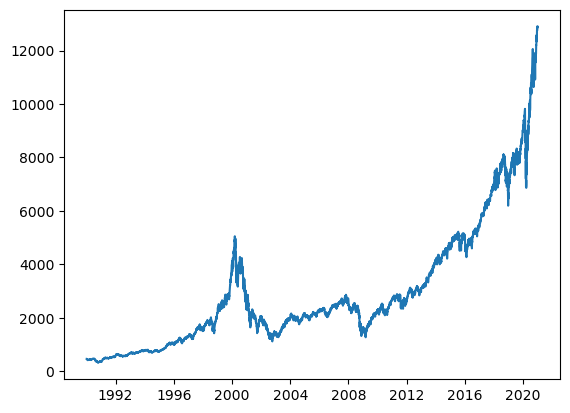

In [12]:
import matplotlib.pyplot as plt

plt.plot(df['Date'],df['Close'])

In [18]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#df=df.dropna(axis=0,how='any')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7812 entries, 0 to 7811
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7812 non-null   datetime64[ns]
 1   Open    7812 non-null   float64       
 2   High    7812 non-null   float64       
 3   Low     7812 non-null   float64       
 4   Close   7812 non-null   float64       
 5   Volume  7812 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 427.2 KB


In [13]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
df=df.dropna(axis=0,how='any')
df1=df['Close']
scalar = MinMaxScaler(feature_range=(0,1))
df1 = scalar.fit_transform(np.array(df1).reshape(-1,1))

In [14]:
df1

array([[0.01064894],
       [0.01077619],
       [0.01065689],
       ...,
       [0.99608716],
       [0.99766026],
       [0.99911407]])

In [21]:
print(df1.shape)

(7812, 1)


In [22]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [23]:
class StockDataset(Dataset):
    def __init__(self,data,seq_len = 100):
        self.data = data
        self.data = torch.from_numpy(data).float().view(-1)
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.data)-self.seq_len-1

    def __getitem__(self, index) :
        return  self.data[index : index+self.seq_len] , self.data[index+self.seq_len]


train_dataset = StockDataset(train_data) 
test_dataset = StockDataset(test_data) 

In [24]:
batch_size = 64
train_dataloader = DataLoader(train_dataset,batch_size,drop_last=True)
test_dataloader = DataLoader(test_dataset,batch_size , drop_last=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [25]:
class Lstm_model(nn.Module):
    def __init__(self, input_dim , hidden_size , num_layers):
        super(Lstm_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_dim , hidden_size = hidden_size , num_layers= num_layers )
        self.fc = nn.Linear(hidden_size,1)

    def forward(self,x,hn,cn):
        out , (hn,cn) = self.lstm(x , (hn,cn))
        final_out = self.fc(out[-1])
        return final_out,hn,cn

    def predict(self,x):
        hn,cn  = self.init()
        final_out = self.fc(out[-1])
        return final_out

    def init(self):
        h0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        c0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        return h0 , c0


input_dim = 1 
hidden_size = 50
num_layers = 4

model = Lstm_model(input_dim , hidden_size , num_layers).to(device)

In [26]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [49]:
def train(dataloader):
    train_loss=[]
    hn , cn = model.init()
    model.train()
    for batch , item in enumerate(dataloader):
        x , y = item
        x = x.to(device)
        y = y.to(device)
        out , hn , cn = model(x.reshape(100,batch_size,1),hn,cn)
        loss = loss_fn(out.reshape(batch_size) , y)
        hn = hn.detach()
        cn = cn.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss)
        if batch == len(dataloader)-1:
            loss = loss.item()
            print(f"train loss: {loss:>7f} ")
        train_loss.append(loss)    

In [50]:
def test(dataloader):
    test_loss=[]
    hn , cn = model.init()
    model.eval()
    for batch , item in enumerate(dataloader):
        x , y = item
        x = x.to(device)
        y = y.to(device)
        out , hn , cn = model(x.reshape(100,batch_size,1),hn,cn)
        loss = loss_fn(out.reshape(batch_size) , y)
        test_loss.append(loss)
        if batch == len(dataloader)-1:
            loss = loss.item()
            print(f"test loss: {loss:>7f} ")
        test_loss.append(loss)    

In [51]:
#train_loss=[]
#test_loss=[]
epochs = 2
for epoch in range(epochs):
    print(f"epoch {epoch} ")
    train(train_dataloader)
    #train_loss.append()
    test(test_dataloader)
    #test_loss.append(b)

epoch 0 
train loss: 0.000670 
test loss: 0.610843 
epoch 1 
train loss: 0.000666 
test loss: 0.610699 


In [52]:
print("train loss :" ,train_loss)
print("val loss : ",test_loss)

train loss : [None, None]
val loss :  [None, None, tensor(0.0118, grad_fn=<MseLossBackward0>), tensor(0.0118, grad_fn=<MseLossBackward0>), tensor(0.0135, grad_fn=<MseLossBackward0>), tensor(0.0135, grad_fn=<MseLossBackward0>), tensor(0.0128, grad_fn=<MseLossBackward0>), tensor(0.0128, grad_fn=<MseLossBackward0>), tensor(0.0111, grad_fn=<MseLossBackward0>), tensor(0.0111, grad_fn=<MseLossBackward0>), tensor(0.0108, grad_fn=<MseLossBackward0>), tensor(0.0108, grad_fn=<MseLossBackward0>), tensor(0.0102, grad_fn=<MseLossBackward0>), tensor(0.0102, grad_fn=<MseLossBackward0>), tensor(0.0091, grad_fn=<MseLossBackward0>), tensor(0.0091, grad_fn=<MseLossBackward0>), tensor(0.0090, grad_fn=<MseLossBackward0>), tensor(0.0090, grad_fn=<MseLossBackward0>), tensor(0.0092, grad_fn=<MseLossBackward0>), tensor(0.0092, grad_fn=<MseLossBackward0>), tensor(0.0086, grad_fn=<MseLossBackward0>), tensor(0.0086, grad_fn=<MseLossBackward0>), tensor(0.0073, grad_fn=<MseLossBackward0>), tensor(0.0073, grad_fn=<M

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


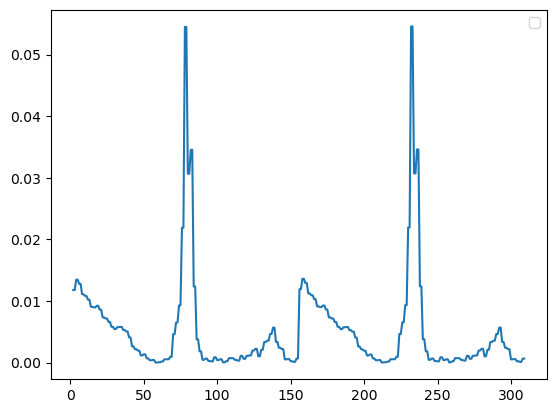

In [55]:
from matplotlib import pyplot as plt
with torch.no_grad():
    #plt.plot(train_loss)   
    plt.plot(test_loss)
    plt.legend()
    plt.show()

In [31]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(data_loader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn , cn = model.init()
        for batch , item in enumerate(data_loader):
            x , y = item
            x , y = x.to(device) , y.to(device)
            x = x.view(100,64,1)
            pred = model(x,hn,cn)[0]
            pred = scalar.inverse_transform(pred.detach().cpu().numpy()).reshape(-1)
            y = scalar.inverse_transform(y.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)
        print(pred_arr[130],y_arr[130])
        return math.sqrt(mean_squared_error(y_arr,pred_arr))

In [32]:
# calculating final loss metrics
print(f"train mse loss {calculate_metrics(train_dataloader)}")
print(f"test mse loss {calculate_metrics(test_dataloader)}")

1939.7319 355.1
train mse loss 905.3985310348145
1941.5354 2704.29
test mse loss 4144.436270471534


In [8]:
(1589360000.0 - 1431042700.0)/1589360000


0.09961072381335884

In [33]:
(4144.436270471534 - 905.3985310348145) /4144.436270471534

0.7815387975716653

In [ ]:
############ https://github.com/abhinav-TB/Time-Series-Forecasting-Using-LSTM/blob/master/pytorch_lstm_time_series_data.ipynb